![banner](../../src/visuals/banner.png)

# Vision Transformer From Scratch

![Vit](https://github.com/google-research/vision_transformer/raw/main/vit_figure.png)

**Code Heavily Inspired by the Following Repositories!!!**

[Huggingface Pytorch Image Models](https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py)



[Lucidrains ViT Pytorch](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/local_vit.py)

[Jankrepl Github Adventures](https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py)

[Karpathy minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py)

### Some Pre-Reqs:
- You should be comfortable in PyTorch at this point and atleast trained one Convolutional Neural Network!

In [13]:
### Import Packages ###
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, Resize, ToTensor
from transformers import get_cosine_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Patch Embedding (The Main Addition Over The Vanilla Transformer)

The purpose of patch embeddings is to convert an Image into a "sequence" type data. To do so we will split an image into patches of size **patch_size** and encode each patch with a vector of length **embed_dim**

![PatchEmbedding](imgs/patch_embeddings.png)


Assume you have an **image of size 3x224x224** and we want to use a **patch_size of 16** and **embed_dim of 768**.

The number of patches can be calculated as $(\dfrac{224}{16})^2 = 196$. Therefore we want to get to the tensor of shape **(196 x 768)** where each patch is being represented with this embedding dimension.

We have two ways to do this:
1) Write a patching funciton to split our image of **(3 x 224 x 224)** to a **(196 x 3 x 14 x 14)**. We can then flatten the last three dimensions and get a tensor of  **(196 x 3\*14\*14)** and then use a linear layer to scale the **3\*14\*14** to our **embed_dim**
2) The prefered method will be to utilize the convolution mechanic in PyTorch to patch the image for us. 
    - The convolution gives us the following iputs and we will fill them as such:
        - in_channels = 3 (We have RGB Images)
        - out_channels = 768 (What is the embed dim we want?)
        - kernel_size = 16 (How large do we want each patch?)
        - stride = 16 (If we dont want any overlapping patches our kernel size and stride have to be the same)
        
    - By doing this, we can essentially have a filter of size 16 traversing over our image with 16 pixel shifts, which will create 196 non-overlapping patches and return the tensor of shape **(768 x 14 x 14)**. We will then flatten on the last dimension to get **(768 x 196)** and then transpose the tensor to get our final output of **(196 x 768)**

In [2]:
class PatchEmbed(nn.Module):
    """
    PatchEmbed module will take an input image in the shape (C, H, W), patch the image into
    patches of size patch_size and embed each patch into embedding dim of embed_dim
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=786):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        ### Calculate Number of Patches ###
        self.n_patches = (img_size // patch_size) ** 2

        ### Use Convolution to Patch the Images ###
        self.proj = nn.Conv2d(in_channels=in_chans,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        x = self.proj(x) # (batch , embed_dim , sqrt(n_patches) , sqrt(n_patches))
        x = x.flatten(2) # (batch , embed_dim , n_patches)
        x = x.transpose(1,2) # (batch, n_patches, embed_dim)
        return x

### Class Tokens and Positional Embeddings
Unfortunately Transformers have an issue of Permuation Invariance. What this means is, if we were doing an NLP task, the Transformer wouldn't pay any attention to the order or words (which is obviously a problem for sequence tasks). Also, we need to be able to aggregate all the information across all the patches into a single vector that can then be used for classification at the end. We will codify these two things later when defining the final VisionTransformer but for now lets review the concept.

![cls_embed](imgs/cls_pos_embed.png)

What we will do first is concatenate onto our original tensor of shape **(196 x 768)** and concatenate on some learnable parameters **CLS_TOKEN** of shape **(1 x 768)** to create our final data shape of **(197 x 768)**. We will then add to this new tensor additional learnable parameters called the **Positional Embeddings** of the shape **(197 x 768)** that will learn to encode spatial (or temporal in sequence tasks) relationships.

### Single Headed Attention

To calculate attention we will have to generate three distinct projections of our data, known as the **Queries**, **Keys** and **Values**. The purpose of this is to use the Queries and Keys to create score weights between different patches of the image and then use that new weight matrix to perform something analogous to a weighted average of the Values matrix.

#### **Step 1: Projection**

We will take our Input Data **(197 x 768)** that includes that **CLS TOKEN** and has the **Positional Embeddings** added to it and project it to three seperate tensors of the same shape. Essentially we are doing three seperate matrix multiplications on weight matricies $W_Q$, $W_K$ , $W_V$ which is the same as doing a simple Linear layer. Because we want the shape to be the same, if we have an input embedding of 768, we will output the same 768, therefore using a Linear layer $nn.Linear(768,768)$

![projection](imgs/projection.png)

#### **Step 2: Build the Attention Matrix**
We will multiply together our Queries and the Transpose of the Keys to generate a tensor of shape **(197 x 197)**. More specifically, we have a matrix of **(num_patches + 1) x (num_patches + 1)** which will encode the relationship between each pair of patches.

![attn](imgs/attn.png)

#### **Step 3: Normalize and Softmax**
Next we divide the resulting Attention matrix by the square root of our embedding length. It was shown that the variance of the attention matrix scaled higher with larger embedding lenghts so this is a simple normalization procedue to make sure the variance of our Q, K and Attention Matrix are all about the same.

More important is our softmax, to ensure that each row of our attention matrix adds to 1. This way, it turns the next calcualation into a simple weighted average of the values. 

$$\text{Attention} = \text{Softmax}(\frac{QK^T}{\sqrt{d_e}})$$

#### **Step 4: Multiply with Values for Output**
We then take our Attention matrix of shape **(197 x 197)** and multiply it with our third projection, the Values with shape **(197 x 768)** giving us the final Output of shape **(197 x 768)**. Notice that the output tensor shape of this entire Attention calculation is identical to the input shape! This allows us to quickly scale the model in the future.

![attn](imgs/prod_w_val.png)

#### **Aside: Couple of Details on why its a Weighted Average**
Pretend our Attention matrix is of shape **(3 x 3)** and the values matrix is of shape **(3 x 768)**. After performing softmax on our attention matrix, each row will sum to one. Therefore, when multiplying with the Values matrix, each row of the Attention martrix is encoding a weighted sum of the embeddings of the values matrix.

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/encoder_attention_vis.png?raw=true" width="800"/>
</div>

In [3]:
class Head(nn.Module):
    """
    Single Attention Head to calculate the Q, K, V and return the weighted average matrix via 3 linear layers
    """
    def __init__(self, embed_dim=768, head_dim=768, attn_p=0):
        super(Head, self).__init__()
        self.query = nn.Linear(embed_dim, head_dim)
        self.key = nn.Linear(embed_dim, head_dim)
        self.value = nn.Linear(embed_dim, head_dim)
        self.attn_dropout = nn.Dropout(attn_p)

    def forward(self, x):
        batch_size, n_patch, embed_dim = x.shape
        q = self.query(x) # (batch, n_patches+1, head_dim)
        k = self.key(x) # (batch, n_patches+1, head_dim)
        v = self.value(x) # (batch, n_patches+1, head_dim)

        sam = (q @ k.transpose(-2,-1)) * embed_dim**-0.5 # (batch , n_patches+1, n_patches+1)
        attn = sam.softmax(dim=-1) # (batch , n_patches+1, n_patches+1)
        attn = self.attn_dropout(attn)
        weighted_average = attn @ v # (batch , n_patches+1, head_dim)
        return weighted_average


### MultiHeaded Attention

MultiHeaded attention only changes one aspect of all the previous ideas we explored. Instead of only have a single set of projections Q, K , V that take input tensor of shape **(197 x 768)** and project to a new tensor of the same shape **(197 x 768)**, what if we do this multiple times? 

The first step is to determine the number of heads we want, and lets say we want 12. This would indicate that the dimension of each head should be  $(\dfrac{768}{12}) = 64$. Therefore, we want to take an input tensor of **(197 x 768)** and project it to a new tensor for the Q, K and V of shape **(197 x 64)**. Again we can do this with a simple linear layer, but instead of $nn.Linear(768, 786)$ we will do $nn.Linear(768, 64)$.

We wil then repeat this step 12 times with 12 unique triplets of linear layers and get 12 outputs each of shape **(197 x 64)**. We can then concatenate all these back together to get the final shape **(197 x 768)**, right back to where we started! The problem here though is we just concatenated the 12 attention heads together, but they never got a chance to share information across one another, therefore we will use another linear layer $nn.Linear(768, 786)$ to perform some information meshing. 

![multihead](imgs/mha.png)

In [4]:
class MultiHeadedAttention(nn.Module):
    """
    Multiple Attention Head to repeat Head module num_heads times and concatenate outputs of heads together.
    """
    def __init__(self, embed_dim=768, num_heads=12, attn_p=0, proj_p=0):
        super(MultiHeadedAttention, self).__init__()
        self.head_size = embed_dim // num_heads
        self.heads = nn.ModuleList([Head(embed_dim=embed_dim, head_dim=self.head_size, attn_p=attn_p) for _ in range(num_heads)])
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (batch, n_patches+1, embed_dim)
        out = self.proj_drop(self.proj(out)) # (batch, n_patches+1, embed_dim)
        return out


### Efficient Attention
As we saw in our MultiHeaded Attention example, we are doing a for loop to pass our tensor through each head. We obviously would like to make this run in parallel so we can put the Attention Head and MultiHeaded Attention together. Another change is, instead of using three seperate linear layers for Q, K and V, we can actually just use a single linear layer $nn.Linear(768, 3*786)$ that essentially outputs the same thing in a single weight matrix. We can then do some fun matrix manipulations to extract our Q,K and V and do our attention calculations. 

There is no good way to draw this, so step through the code below line by line and pay close attention to the shapes of each tensor. 

In [5]:
class EfficientAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_p, proj_p):
        super(EfficientAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_size = int(self.embed_dim / num_heads)

        self.qkv = nn.Linear(embed_dim, embed_dim*3)
        self.attn_dropout = nn.Dropout(attn_p)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        batch, patches, embed_dim = x.shape # (batch, n_patches+1, embed_dim)
        qkv = self.qkv(x) # (batch, n_patches+1, 3*embed_dim)
        qkv = qkv.reshape(batch, patches, 3, self.num_heads, self.head_size) # (batch, patch+1, 3, num_heads, head_size)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch, num_heads, patches+1, head_size)
        q, k, v = qkv[0], qkv[1], qkv[2] # Each of shape (batch, num_heads, patches+1, head_size)

        ### SAME AS BEFORE NOW ###
        sam = (q @ k.transpose(-2,-1)) * self.head_size**-0.5 # (batch, num_heads, patches+1, patches+1)
        attn = sam.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        weighted_average = attn @ v # (batch, num_heads, patches+1, head_size)
        weighted_average = weighted_average.transpose(1,2) # (batch, patches+1, num_heads, head_size)
        weighted_average = weighted_average.flatten(2) # (batch, patches+1, embed_dim)
        out = self.proj_drop(self.proj(weighted_average))
        return out

### MultiLayer Perceptron
As we can see from this small snippet of the image in the original Transformer paper, after performing our MultiHeaded attention calculation, we have a simple Feed Forward module. This is just a typical MLP with a few linear layers, and the only parameter is the **mlp_ratio** which we will specify a little later. The overview is if the input is of dimension 768, then we will have a hidden layer of size 768 * mlp_ratio and then another output layer that will bring it back to a dimension of 768. 
![feedforward](imgs/feedforward.png)

In [6]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, mlp_p=0):
        """
        Hidden features should be some MLP_ratio * in_features. 
        Out Features == In Features
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(mlp_p)

    def forward(self, x):
        x = self.act(self.fc1(x)) # (batch, n_patches+1, embed_dim * mlp_ratio)
        x = self.drop(x)
        x = self.fc2(x) # (batch, n_patches+1, embed_dim)
        x = self.drop(x)
        return x

### Putting Together the **Transformer Block**
In this step we will add in all parts we have build previously together in a transformer block, but there is two new concept we need to look at: 

#### **Layer Normalization**

You should all be familiar with Batch Normalization, but the idea is, throughout the neural network, we will calculate the mean and standard deviation of a tensor across all the batches and use that to normalize our data. There are a few problems with this method that makes it difficult to use in sequence tasks:
- Typically sequence data has different lengths and so we add padding. This wouldnt really work with normalizing across batches because how do we handle the padding tokens?
- It fails with small batch sizes. These models can be very large and so we can only do a small batch size, but that would not be a good sample to estimate population parameters of our mean and standard deviation.
- We often have to train these models across GPUs but BatchNorm would have to sync the calculated mean and std across the GPUS during forward propagation which is messy. 

![layernorm](imgs/layernorm.png)

We then opt for Layernormalization which essentially just normalizes each sample individually across the embedding dimension rather than across the batch. This also means we have to let LayerNormalization know what is the dimension it can expect, and because our embedding dimension is 768, we would have to instantiate it as $nn.LayerNorm(768)$

#### **Residual Connections**
This is inspired by ResNet but as we know, the deeper a Neural Netowrk goes, we have vanishing gradient problems as backpropagation cannot make it back to the start of the model. Therefore to give other paths for gradients to flow back, we will add new calculations to previous ones rather than replace them

In [7]:
class TransformerBlock(nn.Module):
    """
    Full Transformer block with Attention and Linear Layers
    """
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0,
                 mlp_p=0, attn_p=0, proj_p=0, efficient=True):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)

        if efficient:
            self.attn = EfficientAttention(embed_dim=embed_dim,
                                           num_heads=num_heads,
                                           attn_p=attn_p,
                                           proj_p=proj_p)
        else:
            self.attn = MultiHeadedAttention(embed_dim=embed_dim,
                                             num_heads=num_heads,
                                             attn_p=attn_p,
                                             proj_p=proj_p)

        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        hidden_features = int(embed_dim*mlp_ratio)
        self.mlp = MLP(in_features=embed_dim,
                       hidden_features=hidden_features,
                       out_features=embed_dim,
                       mlp_p=mlp_p)

    def forward(self, x):
        """
        Residual connections to avoid vanishing gradients (notice its is X = X + Out rather than doing X = Out)
        """
        x = x + self.attn(self.norm1(x)) # (batch, n_patches+1, embed_dim)
        x = x + self.mlp(self.norm2(x)) # (batch, n_patches+1, embed_dim)
        return x

### Putting Together the **Vision Transformer**
In this next step we will put together all the parts for the Vision Transformer amd there are a few new things included that we talked about previously. 

This is where we will instantiate the **CLS_TOKEN** of shape **(1 x 768)** to concatenate onto our samples and the **Positional Embeddings** of shape **(197 x 768)**. We want the same values of the CLS tokens to be concatenated onto each sample in a batch so each image can have its own unique calculations on it so we will have to expand the dimension to match the batch size in the forward fuction. The Positional Embeddings on the other hand can just be directly added as we want the same positional encoding regardless of the image. 

#### **Input Shape = Output Shape**
I have been making a big deal about the shapes of tensors, and the reason is the unique part of the Transformer Architecture, is the input shape of the transformer block is identical to the output shape. This means we can just stack a bunch of MultiHeaded attention blocks on top of each other and not worry about shape errors. (Rember in convolutions, the shapes can be really hard to match sometimes so this is a huge annoyance saver!)

![stacked](imgs/stacked.png)

#### **Classification Task**
Once we are at the end, we will strip out only the CLS tokens and use that for prediction to our N_classes. In our case we will do Dogs vs Cats so that will be 2 Classes. In the image here I show that I strip of the bottom because I concatenated the cls tokens to the bottom, but in the implemenation it is concatenated to the top! Regardless the idea is the same

![classifier](imgs/classifier.png)

In [8]:
class VisionTransformer(nn.Module):
    """
    VisionTransfomrer put together. Main parameters to change are:
    img_size: Size of input image
    patch_size:  Size of individual patches (Smaller patches lead to more patches)
    n_classes: Number of outputs for classification
    embed_dim: Length of embedding vector for each patch
    depth: Number of wanted transformer blocks
    num_heads: Number of wanted attention heads per block
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, n_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, attn_p=0.2,
                 mlp_p=0.2, proj_p=0.2, pos_drop=0.2, efficient=True):
        super(VisionTransformer, self).__init__()

        self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=in_chans,
                                      embed_dim=embed_dim)

        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter((torch.zeros(1, 1+self.patch_embed.n_patches, embed_dim)))
        self.pos_drop = nn.Dropout(pos_drop)

        self.blocks = nn.ModuleList(
            [
                TransformerBlock(embed_dim=embed_dim,
                                 num_heads=num_heads,
                                 mlp_ratio=mlp_ratio,
                                 mlp_p=mlp_p,
                                 attn_p=attn_p,
                                 proj_p=proj_p,
                                 efficient=efficient)
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x) # (batch, n_patches, embed_dim)
        cls_token = self.cls_token.expand(batch_size, -1, -1) # (batch, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1) # (batch, n_patches+1, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0] # (batch, embed_dim)
        x = self.head(cls_token_final) # (batch, n_classes)
        return x, cls_token_final

### Training Script

At this point everything is done and we just need to train the model!

In [9]:
def train(model, device, epochs, optimizer,
          scheduler, loss_fn, trainloader,
          valloader, savepath="ViTDogsvCatsSmall.pt"):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    best_val_loss = np.inf
    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []

        for image, label in tqdm(trainloader):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            out, _ = model.forward(image)

            ### CALCULATE LOSS ##
            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            ### CALCULATE ACCURACY ###
            predictions = torch.argmax(out, axis=1)
            accuracy = (predictions == label).sum() / len(predictions)
            training_accuracies.append(accuracy.item())

            loss.backward()
            optimizer.step()
            scheduler.step()

        for image, label in tqdm(valloader):
            image, label = image.to(device), label.to(device)
            with torch.no_grad():
                out, _ = model.forward(image)

                ### CALCULATE LOSS ##
                loss = loss_fn(out, label)
                validation_losses.append(loss.item())

                ### CALCULATE ACCURACY ###
                predictions = torch.argmax(out, axis=1)
                accuracy = (predictions == label).sum() / len(predictions)
                validation_accuracies.append(accuracy.item())

        training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)

        ### Save Model If Val Loss Decreases ###
        if valid_loss_mean < best_val_loss:
            print("---Saving Model---")
            torch.save(model.state_dict(), savepath)
            best_val_loss = valid_loss_mean

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)


        print("Training Loss:", training_loss_mean)
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)

    return log_training, model


In [10]:
### Define Model ###
ViT = VisionTransformer(embed_dim=384,
                        depth=6,
                        num_heads=6,
                        efficient=True)

params = sum([np.prod(p.size()) for p in ViT.parameters()])
print(f"Total Number of Parameters: {params}")

### SETUP DATASET ###
PATH_TO_DATA = "../../data/dogsvscats"
dataset = ImageFolder(PATH_TO_DATA)

normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transforms = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    ToTensor(),
    normalizer])

val_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    normalizer])

train_samples, test_samples = int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, lengths=[train_samples, test_samples])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

### SETUP TRAINING LOOP ###
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Training on Device {}".format(DEVICE))

### Define Optimizer ###
optimizer = optim.AdamW(params=ViT.parameters(), lr=1e-3)

### Define Loss ###
loss_fn = nn.CrossEntropyLoss()

### Build DataLoaders ###
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Define Scheduler ###
EPOCHS = 10
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=250, 
                                            num_training_steps=EPOCHS*len(trainloader))

logs, model = train(model=ViT.to(DEVICE),
                    device=DEVICE,
                    epochs=EPOCHS,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    loss_fn=loss_fn,
                    trainloader=trainloader,
                    valloader=valloader)


Total Number of Parameters: 11019650
Training on Device cuda
Starting Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.51it/s]


---Saving Model---
Training Loss: 0.690351185134866
Training Acc: 0.5581414601342245
Validation Loss: 0.6670368731021881
Validation Acc: 0.5755418330430985
Starting Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.49it/s]


---Saving Model---
Training Loss: 0.6622089144181121
Training Acc: 0.5893230766735293
Validation Loss: 0.6523669272661209
Validation Acc: 0.5856224775314331
Starting Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.65it/s]


---Saving Model---
Training Loss: 0.6297501359473575
Training Acc: 0.6360025243325667
Validation Loss: 0.6316250473260879
Validation Acc: 0.6130922377109528
Starting Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.44it/s]


Training Loss: 0.6043617755851962
Training Acc: 0.6627800119194117
Validation Loss: 0.642486983537674
Validation Acc: 0.6466607868671417
Starting Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.45it/s]


---Saving Model---
Training Loss: 0.6010981735519387
Training Acc: 0.6711695715785027
Validation Loss: 0.5780501037836074
Validation Acc: 0.6905871957540513
Starting Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.54it/s]


Training Loss: 0.5996295057914474
Training Acc: 0.6694827818057754
Validation Loss: 0.6060311734676361
Validation Acc: 0.6560609877109528
Starting Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.55it/s]


Training Loss: 0.603727553378452
Training Acc: 0.6701210266487165
Validation Loss: 0.6828940451145172
Validation Acc: 0.5974168330430984
Starting Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.66it/s]


---Saving Model---
Training Loss: 0.5848987026309426
Training Acc: 0.6845199249007485
Validation Loss: 0.5717542409896851
Validation Acc: 0.7013986885547638
Starting Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.56it/s]


---Saving Model---
Training Loss: 0.5528169636699286
Training Acc: 0.7160710516301069
Validation Loss: 0.5483840882778168
Validation Acc: 0.7300655245780945
Starting Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.41it/s]


---Saving Model---
Training Loss: 0.5224479431794449
Training Acc: 0.735018043694171
Validation Loss: 0.5364581435918808
Validation Acc: 0.7334803402423858


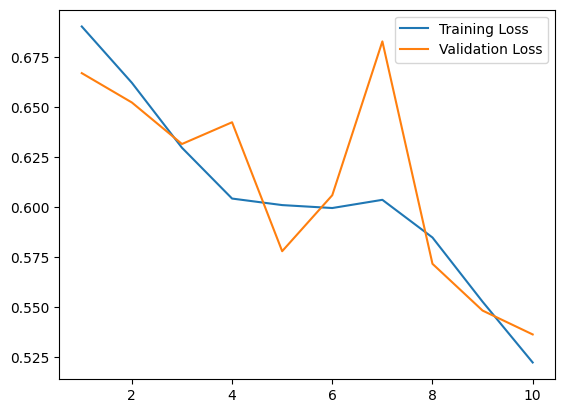

In [20]:
plt.plot(logs["epoch"], logs["training_loss"], label="Training Loss") 
plt.plot(logs["epoch"], logs["validation_loss"], label="Validation Loss")
plt.legend()
plt.show()